In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import string
import os
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from shapely.geometry import Point



Load Files

In [17]:
def load_reviews(file_name):
    f = open(file_name) 
    data = json.load(f)

    df_list = []
    for restaurant, reviews in data.items():
        normalized_df = pd.json_normalize(reviews)
        normalized_df['restaurant'] = restaurant
        filtered_df = normalized_df.dropna(axis=1, how='all')
        df_list.append(filtered_df)

    return pd.concat(df_list, ignore_index=True)

reviews = []
path = "{}/reviews".format(os.getcwd())
for file_name in os.listdir(path):
    with open(path+'/'+file_name, "r") as json_file:
        reviews.append(load_reviews(path+'/'+file_name))
df_reviews = pd.concat(reviews, ignore_index=True)
    


In [18]:
df_reviews['photoCount'].fillna(0,inplace=True)
df_reviews.drop_duplicates()
df_reviews

,reviewCount,localizedDate,rating,comment.text,comment.language,restaurant,photoCount,eliteYear
0,6,8/6/2013,4,I tried this cart for the first time today and...,en,yummy-fawl-and-falafel-cart-new-york,0.0,NaN
1,1357,11/7/2023,5,The buffet is a welcome destination for the in...,en,yips-new-york-4,4814.0,2023.0
2,281,8/7/2023,5,Great value and good food for a quick lunch in...,en,yips-new-york-4,981.0,2023.0
3,175,7/18/2023,5,OMG delicious! While they may not have the sam...,en,yips-new-york-4,11.0,2023.0
4,627,3/23/2023,4,Came back today. They had a special for a few ...,en,yips-new-york-4,2055.0,2023.0
...,...,...,...,...,...,...,...,...
331688,80,10/26/2011,3,The Feeding Tree is precisely the type enterpr...,en,eating-tree-bronx,767.0,NaN
331689,1261,6/4/2010,4,Now this is a classic Bronx eatery. Its small...,en,eating-tree-bronx,44.0,2023.0
331690,23,10/18/2018,3,Good prices and actually not bad jamaican food...,en,eating-tree-bronx,5.0,NaN
331691,25,9/20/2018,5,I ordered stewed oxtail and a beef patty throu...,en,eating-tree-bronx,35.0,NaN


In [20]:
def load_restaurant_data(file_name):
    f = open(file_name) 
    data = json.load(f)
    df_list = []
    for restaurant, info in data.items():
        normalized_df = pd.json_normalize(info)
        normalized_df['restaurant'] = restaurant
        filtered_df = normalized_df.dropna(axis=1, how='all')
        df_list.append(filtered_df)

    # Concatenate all dataframes
    df_restaurants = pd.concat(df_list, ignore_index=True)
    return flatten_category(df_restaurants)


def extract_titles(row):
    # Extracting 'title' from each column if it is not None, otherwise using None
    return [row[i]['title'] if row[i] is not None else None for i in range(len(row))]

def flatten_category(df):
    new_category = pd.json_normalize(df['categories'])
    category_df = new_category.apply(extract_titles, axis=1, result_type='expand')

    # Renaming the columns
    category_df.columns = [f'category_{i}' for i in range(new_category.shape[1])]

    # Concatenate with the original dataframe if needed
    df = pd.concat([df, category_df], axis=1)
    return df


df_restaurants = load_restaurant_data('restaurants.json')
#df_restaurants2 = load_restaurant_data('restaurants2.json')
#df_restaurants = pd.concat([df_restaurants1,df_restaurants2], ignore_index=True)


In [21]:
michelin = json.load(open("michelin_alias.json") )
df_restaurants['is_michelin'] = [1 if i in michelin.values() else 0 for i in df_restaurants['restaurant']]

In [22]:
# exclude 8 brooklyn restaurants
'''
print(df_restaurants['is_michelin'].sum())
print(len(michelin.values()))

set_data = set(df_restaurants[df_restaurants['is_michelin']==1]['restaurant'])
set_michelin = set(michelin.values())

print(set_michelin-set_data) 
print(len(set_michelin-set_data))
print(len(set_michelin))
print(len(set_data))
'''

"\nprint(df_restaurants['is_michelin'].sum())\nprint(len(michelin.values()))\n\nset_data = set(df_restaurants[df_restaurants['is_michelin']==1]['restaurant'])\nset_michelin = set(michelin.values())\n\nprint(set_michelin-set_data) \nprint(len(set_michelin-set_data))\nprint(len(set_michelin))\nprint(len(set_data))\n"

In [23]:
df_restaurants.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,location.country,location.state,location.display_address,restaurant,location.address3,category_0,category_1,category_2,category_3,is_michelin
0,ce605OMECZ3jLZtk6dCDHA,le-pain-quotidien-new-york-137,Le Pain Quotidien,https://s3-media3.fl.yelpcdn.com/bphoto/z-YqDX...,False,https://www.yelp.com/biz/le-pain-quotidien-new...,84,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",3.0,"[pickup, delivery]",...,US,NY,"[395 S End Ave, New York, NY 10280]",le-pain-quotidien-new-york-137,NaN,Coffee & Tea,Bakeries,Breakfast & Brunch,None,0
1,B8yFj4qt-HgMCbF5S-GkgA,creperie-new-york-6,Creperie,https://s3-media1.fl.yelpcdn.com/bphoto/uydGkc...,False,https://www.yelp.com/biz/creperie-new-york-6?a...,19,"[{'alias': 'creperies', 'title': 'Creperies'}]",2.5,[],...,US,NY,"[255 Liberty St, New York, NY 10281]",creperie-new-york-6,NaN,Creperies,None,None,None,0
2,WZLhPYaYSFy7M_-Jh1VuNw,dos-toros-taqueria-new-york-5,Dos Toros Taqueria,https://s3-media1.fl.yelpcdn.com/bphoto/fNdfBJ...,False,https://www.yelp.com/biz/dos-toros-taqueria-ne...,132,"[{'alias': 'mexican', 'title': 'Mexican'}]",3.5,[],...,US,NY,"[225 Liberty St, Ste 242, New York, NY 10281]",dos-toros-taqueria-new-york-5,,Mexican,None,None,None,0
3,tFQRwk9SVOFgpMBZ55UrLw,umami-burger-new-york-17,Umami Burger,https://s3-media2.fl.yelpcdn.com/bphoto/uvquI3...,False,https://www.yelp.com/biz/umami-burger-new-york...,333,"[{'alias': 'burgers', 'title': 'Burgers'}]",3.0,"[delivery, pickup]",...,US,NY,"[225 Liberty St, Ste 247, New York, NY 10281]",umami-burger-new-york-17,,Burgers,None,None,None,0
4,jhs35REmv8Yo9-Z27KQJSA,naya-brookfield-place-new-york-3,NAYA - Brookfield Place,https://s3-media3.fl.yelpcdn.com/bphoto/Zd6LgX...,False,https://www.yelp.com/biz/naya-brookfield-place...,32,"[{'alias': 'mediterranean', 'title': 'Mediterr...",4.5,"[pickup, delivery]",...,US,NY,"[225 Liberty St, Fl 2, New York, NY 10281]",naya-brookfield-place-new-york-3,,Mediterranean,Lebanese,None,None,0


Descriptive Statistics

In [8]:
df_reviews_stat = df_reviews[['restaurant', 'photoCount']].groupby('restaurant').count().rename(columns={'photoCount':'reviews_cnt'})
df_reviews_stat['elite_reviews_cnt'] = df_reviews[['restaurant', 'eliteYear']].groupby('restaurant').count()['eliteYear']
df_reviews_stat['elite_reviews_perc'] = df_reviews_stat['elite_reviews_cnt']/df_reviews_stat['reviews_cnt']
df_reviews_stat['user_photo_cnt_avg'] = df_reviews[['restaurant', 'photoCount']].groupby('restaurant').mean()['photoCount']
df_reviews_stat['user_review_cnt_avg'] = df_reviews[['restaurant', 'reviewCount']].groupby('restaurant').mean()['reviewCount']
df_reviews_stat['rating_avg'] = df_reviews[['restaurant', 'rating']].groupby('restaurant').mean()['rating']
df_reviews_stat['rating_med'] = df_reviews[['restaurant', 'rating']].groupby('restaurant').median()['rating']
df_reviews_stat['rating_std'] = df_reviews[['restaurant', 'rating']].groupby('restaurant').std()['rating']
df_reviews_stat
# df_reviews[['photoCount','reviewCount','eliteYear','rating','restaurant']].groupby('restaurant').aggregate([np.mean])

,reviews_cnt,elite_reviews_cnt,elite_reviews_perc,user_photo_cnt_avg,user_review_cnt_avg,rating_avg,rating_med,rating_std
restaurant,,,,,,,,
1-bite-mediterranean-new-york,17,1,0.058824,36.176471,134.588235,3.058824,3.0,1.344925
1-chimi-sushi-new-york,15,2,0.133333,1983.400000,525.933333,2.933333,3.0,1.533747
1-columbia-deli-new-york,5,0,0.000000,2.800000,9.200000,1.800000,1.0,1.788854
1-dollar-pizza-new-york,50,14,0.280000,816.540000,304.920000,3.440000,4.0,1.514016
1-minute-cafe-new-york-2,1,0,0.000000,0.000000,8.000000,2.000000,2.0,NaN
...,...,...,...,...,...,...,...,...
zzs-clam-bar-new-york,50,10,0.200000,633.340000,315.660000,4.260000,5.0,1.157231
çka-ka-qëllu-new-york-3,50,30,0.600000,740.680000,264.520000,4.520000,5.0,0.762381
épicerie-boulud-new-york-6,50,22,0.440000,910.640000,348.120000,3.760000,4.0,1.238168


In [9]:
df_final = pd.merge(df_restaurants, df_reviews_stat, how='inner', on='restaurant')
df_final

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,category_3,is_michelin,reviews_cnt,elite_reviews_cnt,elite_reviews_perc,user_photo_cnt_avg,user_review_cnt_avg,rating_avg,rating_med,rating_std
0,ce605OMECZ3jLZtk6dCDHA,le-pain-quotidien-new-york-137,Le Pain Quotidien,https://s3-media3.fl.yelpcdn.com/bphoto/z-YqDX...,False,https://www.yelp.com/biz/le-pain-quotidien-new...,84,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",3.0,"[pickup, delivery]",...,None,0,50,16,0.320000,755.900000,199.860000,3.320000,4.0,1.531173
1,B8yFj4qt-HgMCbF5S-GkgA,creperie-new-york-6,Creperie,https://s3-media1.fl.yelpcdn.com/bphoto/uydGkc...,False,https://www.yelp.com/biz/creperie-new-york-6?a...,19,"[{'alias': 'creperies', 'title': 'Creperies'}]",2.5,[],...,None,0,19,1,0.052632,654.894737,244.842105,2.631579,2.0,1.300022
2,WZLhPYaYSFy7M_-Jh1VuNw,dos-toros-taqueria-new-york-5,Dos Toros Taqueria,https://s3-media1.fl.yelpcdn.com/bphoto/fNdfBJ...,False,https://www.yelp.com/biz/dos-toros-taqueria-ne...,132,"[{'alias': 'mexican', 'title': 'Mexican'}]",3.5,[],...,None,0,50,24,0.480000,3183.000000,365.740000,4.040000,4.0,1.159873
3,tFQRwk9SVOFgpMBZ55UrLw,umami-burger-new-york-17,Umami Burger,https://s3-media2.fl.yelpcdn.com/bphoto/uvquI3...,False,https://www.yelp.com/biz/umami-burger-new-york...,333,"[{'alias': 'burgers', 'title': 'Burgers'}]",3.0,"[delivery, pickup]",...,None,0,50,34,0.680000,941.800000,424.520000,3.240000,3.5,1.378553
4,jhs35REmv8Yo9-Z27KQJSA,naya-brookfield-place-new-york-3,NAYA - Brookfield Place,https://s3-media3.fl.yelpcdn.com/bphoto/Zd6LgX...,False,https://www.yelp.com/biz/naya-brookfield-place...,32,"[{'alias': 'mediterranean', 'title': 'Mediterr...",4.5,"[pickup, delivery]",...,None,0,32,15,0.468750,603.875000,252.406250,4.250000,5.0,1.077632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10872,J0V2C6wAkHMLD9j7I50_ZQ,sgd-dubu-so-gong-dong-tofu-and-bbq-edgewater-2,SGD Dubu So Gong Dong Tofu & BBQ,https://s3-media3.fl.yelpcdn.com/bphoto/xX4DnY...,False,https://www.yelp.com/biz/sgd-dubu-so-gong-dong...,228,"[{'alias': 'korean', 'title': 'Korean'}, {'ali...",4.0,[delivery],...,None,0,50,28,0.560000,979.220000,312.580000,3.860000,4.0,1.143036
10873,awvl9pC0RW8PT5A3NeLGMg,fuxingmei-sushi-house-edgewater,FuXingMei Sushi House,https://s3-media1.fl.yelpcdn.com/bphoto/ZgikoA...,False,https://www.yelp.com/biz/fuxingmei-sushi-house...,94,"[{'alias': 'japanese', 'title': 'Japanese'}, {...",4.0,"[delivery, pickup]",...,None,0,50,16,0.320000,609.660000,186.440000,4.000000,4.0,1.195229
10874,JmhZW6euOW_7L3E3v4fpKg,happy-wok-bronx,Happy Wok,,False,https://www.yelp.com/biz/happy-wok-bronx?adjus...,6,"[{'alias': 'chinese', 'title': 'Chinese'}]",2.0,"[delivery, pickup]",...,None,0,6,0,0.000000,1.833333,5.833333,2.166667,1.0,1.834848
10875,S55v4pq633nTz7jbGmrCfg,justins-pizza-bronx,Justin's Pizza,https://s3-media2.fl.yelpcdn.com/bphoto/CH79G2...,False,https://www.yelp.com/biz/justins-pizza-bronx?a...,18,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",2.5,"[delivery, pickup]",...,None,0,18,1,0.055556,3847.222222,312.888889,2.611111,2.0,1.685191


In [10]:
df_final.columns

Index(['id', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count',
       'categories', 'rating', 'transactions', 'price', 'phone',
       'display_phone', 'distance', 'coordinates.latitude',
       'coordinates.longitude', 'location.address1', 'location.address2',
       'location.address3', 'location.city', 'location.zip_code',
       'location.country', 'location.state', 'location.display_address',
       'restaurant', 'category_0', 'category_1', 'category_2', 'category_3',
       'is_michelin', 'reviews_cnt', 'elite_reviews_cnt', 'elite_reviews_perc',
       'user_photo_cnt_avg', 'user_review_cnt_avg', 'rating_avg', 'rating_med',
       'rating_std'],
      dtype='object')

Visualizations
-- Michelin Restaurant Profile

Geomap

In [12]:
# Create a map centered around New York City
nyc_coordinates = (40.7128, -74.0060)  # Latitude and Longitude of NYC
nyc_map = folium.Map(location=nyc_coordinates, zoom_start=12)

michelin_df = df_final[df_final['is_michelin'] == True]

# Iterate over the Michelin-starred restaurant DataFrame
for _, row in michelin_df.iterrows():
    # Define the popup message including name, categories, ratings, and price
    categories = ', '.join([row[f'category_{i}'] for i in range(4) if row[f'category_{i}']])

    popup_message = folium.Popup((f"{row['name']}\n"
                                  f"Cuisine: {categories}\n"
                                  f"Rating: {row['rating']}\n"
                                  f"Price: {row['price']}"),
                                  parse_html=False)

    # Create a marker and add it to the map
    folium.Marker(
        location=(row['coordinates.latitude'], row['coordinates.longitude']),
        popup=popup_message,
        icon=folium.Icon(color='red', icon='star')
    ).add_to(nyc_map)

# Display the map
nyc_map


In [33]:
## Heat map does not work well in general because of large variability in restaurant data, but here's the code
# Preprocess Data: Convert price to numerical values
price_mapping = {'$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
df_final['price_numeric'] = df_final['price'].map(price_mapping)

# Remove rows with missing data
df_final = df_final.dropna(subset=['coordinates.latitude', 'coordinates.longitude', 'review_count'])

# Create a base map
nyc_coordinates = (40.7128, -74.0060)
nyc_map = folium.Map(location=nyc_coordinates, zoom_start=12)

# Prepare data for the heatmap
heat_data = [[row['coordinates.latitude'], row['coordinates.longitude'], row['review_count']]
             for index, row in df_final.iterrows()]

# Add heatmap to the map
HeatMap(heat_data).add_to(nyc_map)

# Display the map
nyc_map


/tmp/ipykernel_963/3802756966.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['price_numeric'] = df_final['price'].map(price_mapping)


In [13]:
## Heat map does not work well in general because of large variability in restaurant data, but here's the code

# Create a map centered around New York City
nyc_coordinates = (40.7128, -74.0060)  # Latitude and Longitude of NYC
nyc_map = folium.Map(location=nyc_coordinates, zoom_start=12)

# Extract the necessary data from the DataFrame
# We need latitude, longitude, and the count of reviews
heat_data = [[row['coordinates.latitude'], row['coordinates.longitude'], row['reviews_cnt']]
             for index, row in df_final.iterrows()]

# Create and add a HeatMap layer to the map
HeatMap(heat_data).add_to(nyc_map)

# Display the map
nyc_map


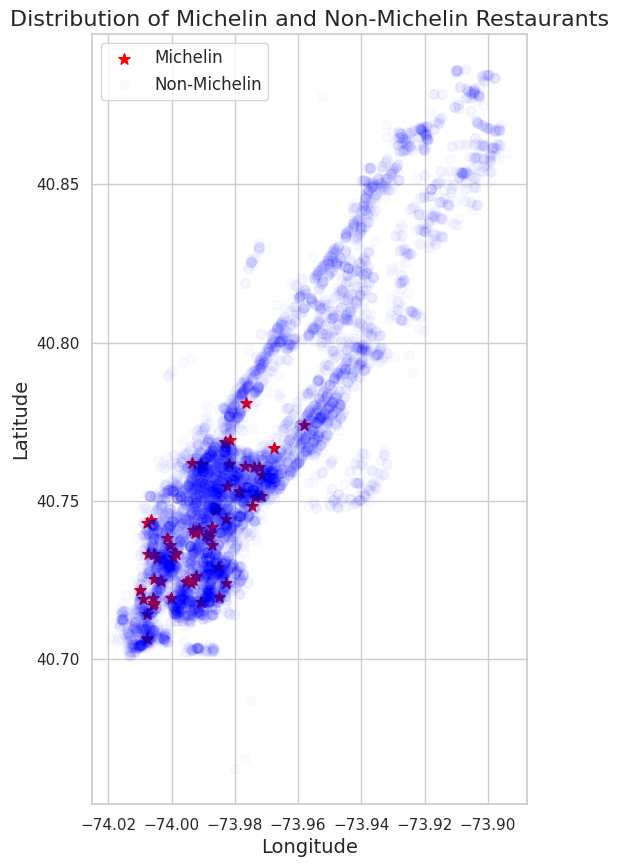

In [40]:
gdf = gpd.GeoDataFrame(
    df_final, 
    geometry=gpd.points_from_xy(df_final['coordinates.longitude'], df_final['coordinates.latitude'])
)

fig, ax = plt.subplots(figsize=(10, 10))
michelin_base = gdf[gdf['is_michelin'] == 1].plot(ax=ax, markersize=70, color='red', label='Michelin', marker='*')
gdf[gdf['is_michelin'] == 0].plot(ax=michelin_base, markersize=50, color='blue', label='Non-Michelin', alpha=0.02, marker='o')

ax.legend(prop={'size': 12})
ax.set_title('Distribution of Michelin and Non-Michelin Restaurants', fontsize=16)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.grid(True)
plt.show()

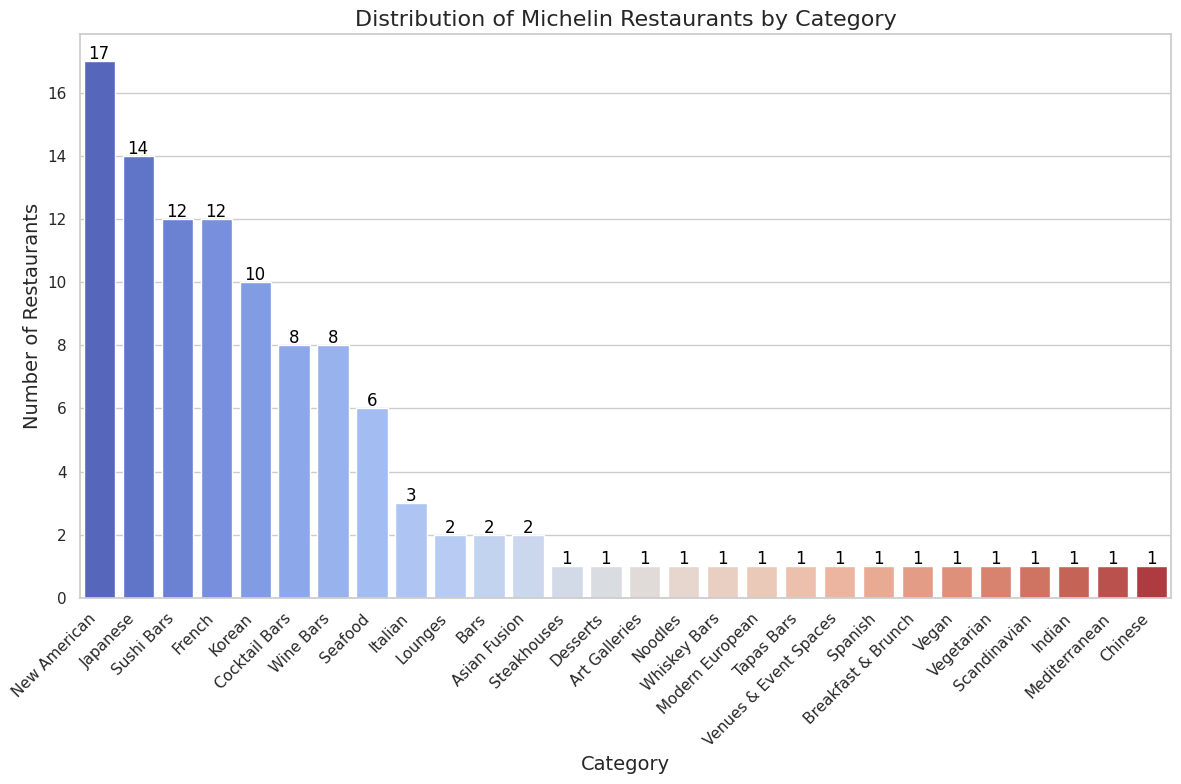

In [31]:
melted_df = michelin_df.melt(id_vars=["id", "name"], value_vars=["category_0", "category_1", "category_2", "category_3"], var_name="category_type", value_name="category").dropna()

# Counting the occurrences of each category
category_counts = melted_df['category'].value_counts()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, palette="coolwarm", legend=False)


plt.title('Distribution of Michelin Restaurants by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Restaurants', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate and align labels to the right for better readability

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5),
                textcoords='offset points')
    
plt.tight_layout()
plt.show()